## CS345 Fall 2022 Assignment 2


### Preliminaries

We'll start with a review of the notation used to represent a dataset. In supervised learning we work with a dataset of $N$ labeled examples: $\mathcal{D} = \{ (\mathbf{x}_i, y_i) \}_{i=1}^N$, where $\mathbf{x}_i$ is a $d$-dimensional vector (we always use boldface to denote vectors), and $y_i$ is the label associated with $\mathbf{x}_i$.  For the perceptron algorithm we used the labels $\pm 1$, so make sure that is the case for the data you read in.

Datasets:

* The [Gisette](http://archive.ics.uci.edu/ml/datasets/Gisette) handwritten digit recognition dataset. For this dataset use the separately provided validation set for testing your classifiers.
* The [QSAR](http://archive.ics.uci.edu/ml/datasets/QSAR+biodegradation) data for predicting the biochemical activity of a molecule.
* The [heart disease diagnosis](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) dataset.
* The [Wisconsin breast cancer wisconsin dataset](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_breast_cancer.html#sklearn.datasets.load_breast_cancer).
* For developing your code, you can use one of the scikit-learn datasets, such as the [make_classification](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html#sklearn.datasets.make_classification) toy dataset generator.
  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer, make_classification
from sklearn.model_selection import train_test_split

def data_is_valid(X, y, examples=0, features=0):
    return (
        X.shape == (examples, features)
        and y.shape == (examples,)
        and not np.any(np.isnan(X))
        and np.all(np.unique(y) == [-1,1])
    )

In [2]:
# Load digit recognition dataset
gisette_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/gisette/"

gisette_train_X = pd.read_csv(gisette_url+'GISETTE/gisette_train.data', sep=' ', header=None).values[:,:-1]
gisette_train_y = pd.read_csv(gisette_url+'GISETTE/gisette_train.labels', header=None).values.T[0]

assert(data_is_valid(gisette_train_X, gisette_train_y, examples=6000, features=5000))

gisette_test_X = pd.read_csv(gisette_url+'GISETTE/gisette_valid.data', sep=' ', header=None).values[:,:-1]
gisette_test_y = pd.read_csv(gisette_url+'gisette_valid.labels', header=None).values.T[0]

assert(data_is_valid(gisette_test_X, gisette_test_y, examples=1000, features=5000))


# Load biochemical activity dataset
biodeg_url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv'

biodeg_data = pd.read_csv(biodeg_url, sep=';', header=None).values

biodeg_X = np.array(biodeg_data[:,:-1], dtype=np.float64)
biodeg_y = 2*(biodeg_data[:,-1] == 'RB') - 1

assert(data_is_valid(biodeg_X, biodeg_y, examples=1055, features=41))


# Load heart disease dataset
heart_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"

heart_data = pd.read_csv(heart_url, header=None, na_values='?', dtype=np.float64).values
nan_examples = np.any(np.isnan(heart_data), axis=1)
heart_data = heart_data[~nan_examples]

heart_X = heart_data[:,:-1]
heart_y = np.sign(heart_data[:,-1] - 0.5)

assert(data_is_valid(heart_X, heart_y, examples=297, features=13))


# Load breast cancer dataset
cancer_X, cancer_y = load_breast_cancer(return_X_y = True)
cancer_y = 2*cancer_y - 1

assert(data_is_valid(cancer_X, cancer_y, examples=569, features=30))


# Make toy dataset
toy_X, toy_y = make_classification(
    n_samples=100, n_features=10, n_informative=10, n_redundant=0, n_repeated=0,
    n_classes=2, n_clusters_per_class=1, class_sep=0.35, random_state=1
)
toy_y = 2*toy_y - 1

assert(data_is_valid(toy_X, toy_y, examples=100, features=10))

## Part 1:  Variation on the perceptron algorithm 

In this part of the assignment you will work with the perceptron and an additional variant we will call the **ensemble perceptron**.
It is created by averaging the votes of multiple perceptron models to create a prediction.
Ensemble learning is a common theme in machine learning, and later in the semester we will see algorithms specifically designed for this purpose.  In this assignment we will create a very simple implementation of this idea.
The idea leverages a phenomenon known as [the wisdom of the crowd](https://en.wikipedia.org/wiki/Wisdom_of_the_crowd), namely that a collection of predictions of diverse experts (or even non experts), can, when aggregated lead to incredibly accurate predictions.


**The idea:**  Rather than using a single classifier for making a prediction, use an average of the predictions made by multiple perceptrons trained on the same dataset.  This can lead to more robust and accurate predictions.

Here are the details of the training algorithm:

**Ensemble perceptron**

**Input:** number of perceptrons in the ensemble (`num_classifiers`).

**Output:**  a list of perceptron classifiers.

**Training:**
* Train `num_classifiers` perceptrons, each with a different initial weight vector (this is important!!!).  Each perceptron will be trained until convergence, or until a fixed number of epochs has passed (recall that an epoch is a loop over all the training data).

**prediction:**

* **decision_function:** Let $f_i(\mathbf{x})$ be the decision function of perceptron $i$.  Then the decision function of the ensemble is defined as 

$$
f(\mathbf{x}) = \frac{1}{\mathrm{num\_classifiers}} \sum_{i=1}^{\mathrm{num\_classifiers}} f_i(\mathbf{x})
$$

* **predict:**  The predict function will return $\mathrm{sign}(f(\mathbf{x}))$ where $f(\mathbf{x})$ is the value of the decision function defined above.



Here's what you need to do:

- Implement the ensemble perceptron as a Python class called `ensemble_perceptron` using the same interface used in the code provided for the perceptron algorithm, i.e. provides the same methods with the same signature.  In each case make sure that your implementation **includes a bias term as described in the perceptron notebook** where you will find guidance on how to add a bias term to an algorithm that is expressed without one.

- Compare the performance of the ensemble perceptron with the regular perceptron on the QSAR and breast cancer diagnosis datasets. Do so by estimating the accuracy on a sample of the data that you reserve for testing (the test set).  In each case reserve  70% of the data for training, and 30% for testing.  To gain more confidence in our error estimates, repeat this experiment using 10 random splits of the data into training/test sets for each algorithm.  It is best to use the same train-test splits for each algorithm.  Report the average accuracy and its standard deviation in a nicely formatted table.  Is there a version of the perceptron that appears to perform better?   (In answering this, consider the differences in performance you observe in comparison to the standard deviation).  Make sure to let the algorithm run for a sufficient number of epochs.

A note about the classifier API:  in this course we follow the scikit-learn classifier API, which requires that a classifier have the following methods (in addition to a constructor):

* `fit(X, y)`:  trains a classifier using a feature matrix `X` and a labels vector `y`.
* `predict(X)`:  given a feature matrix `X`, return a vector of labels for each feature vector represented by `X`.

For those interested in more information about the scikit-learn API, here's a [link](https://scikit-learn.org/stable/developers/develop.html).


In [3]:
class perceptron: 
    def __init__(self, iterations=100, learning_rate=0.2):
        self.iterations = iterations
        self.learning_rate = learning_rate
        self.converged = False
  
    def fit(self, X, y):
        X_mod = self.add_constant_feature(X)
        rng = np.random.default_rng()
        self.w = rng.uniform(-1, 1, len(X[0]) + 1)

        converged = False
        iteration = 0
        while (not converged and iteration <= self.iterations):
            converged = True
            for i in range(len(X_mod)):
                if y[i] * self.decide(X_mod[i]) <= 0:
                    self.w += y[i] * self.learning_rate * X_mod[i]
                    converged = False
            iteration += 1
        
        self.converged = converged
 
    def predict(self, X):
        X_mod = self.add_constant_feature(X)
        scores = self.decide(X_mod)
        return np.sign(scores)

    def decide(self, x):
        return np.dot(x, self.w)

    def add_constant_feature(self, X):
        return np.hstack((X, np.ones((len(X), 1))))

class ensemble_perceptron :
    def __init__(self, num_classifiers=50, iterations=100, learning_rate=0.2):
        self.ensemble = [perceptron(iterations, learning_rate) for i in range(num_classifiers)]

    def fit(self, X, y):
        for p in self.ensemble:
            p.fit(X, y)
    
    def predict(self, X):
        avg_scores = np.mean([p.predict(X) for p in self.ensemble], axis = 0)
        return np.sign(avg_scores)

In [4]:
epochs = 100
ensemble_size = 10

p = perceptron(iterations = epochs)
single_accuracies_cancer = []
single_accuracies_biodeg = []

pe = ensemble_perceptron(num_classifiers = ensemble_size, iterations = epochs)
ensemble_accuracies_cancer = []
ensemble_accuracies_biodeg = []

for i in range(10):
    cancer_train_X, cancer_test_X, cancer_train_y, cancer_test_y = train_test_split(cancer_X, cancer_y, test_size=0.3)
    biodeg_train_X, biodeg_test_X, biodeg_train_y, biodeg_test_y = train_test_split(biodeg_X, biodeg_y, test_size=0.3)

    p.fit(cancer_train_X, cancer_train_y)
    single_accuracies_cancer.append(
        np.mean(cancer_test_y == p.predict(cancer_test_X))
    )

    p.fit(biodeg_train_X, biodeg_train_y)
    single_accuracies_biodeg.append(
        np.mean(biodeg_test_y == p.predict(biodeg_test_X))
    )

    pe.fit(cancer_train_X, cancer_train_y)
    ensemble_accuracies_cancer.append(
        np.mean(cancer_test_y == pe.predict(cancer_test_X))
    )

    pe.fit(biodeg_train_X, biodeg_train_y)
    ensemble_accuracies_biodeg.append(
        np.mean(biodeg_test_y == pe.predict(biodeg_test_X))
    )

data = [
    ['Single, cancer', np.mean(single_accuracies_cancer), np.std(single_accuracies_cancer)],
    ['Ensemble, cancer', np.mean(ensemble_accuracies_cancer), np.std(ensemble_accuracies_cancer)],
    ['Single, biodeg', np.mean(single_accuracies_biodeg), np.std(single_accuracies_biodeg)],
    ['Ensemble, biodeg', np.mean(ensemble_accuracies_biodeg), np.std(ensemble_accuracies_biodeg)]
]
pd.DataFrame(data, columns = ['', 'Mean', 'StdDev'])

,,Mean,StdDev
0,"Single, cancer",0.835088,0.111719
1,"Ensemble, cancer",0.841520,0.112592
2,"Single, biodeg",0.775079,0.049216
3,"Ensemble, biodeg",0.751420,0.065168


*observations*

## Part 2:  Learning Curves 

Whenever we train a classifier it is useful to know if we have collected a sufficient amount of data for accurate classification.  A good way of determining that is to construct a **learning curve**, which is a plot of classifier performance as a function of the number of training examples.  Plot a learning curve for the perceptron algorithm using the Gisette dataset.  You can use the Gisette validation set for testing purposes.  The x-axis for the plot (number of training examples) should be on a logarithmic scale - something like 10,20,40,80,200,400,800.  Use numbers that are appropriate for the dataset at hand, choosing values that illustrate the variation that you observe.  What can you conclude from the learning curve you have constructed for this particular dataset?
In answering this question, you can use the following [wikipedia article](https://en.wikipedia.org/wiki/Learning_curve#In_machine_learning).
Make sure that you use a fixed test set to evaluate performance while varying the size of the training set.


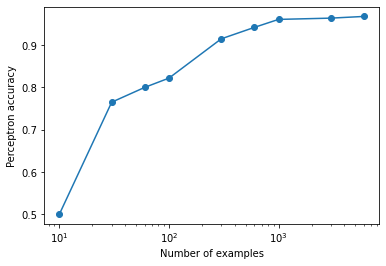

In [5]:
num_examples = [10, 30, 60, 100, 300, 600, 1000, 3000, 6000]
accuracies = []

for n in num_examples:
    p = perceptron()
    X, y = gisette_train_X[:n, :], gisette_train_y[:n]
    p.fit(X, y)
    accuracies.append(np.mean(gisette_test_y == p.predict(gisette_test_X)))

plt.semilogx(num_examples, accuracies, marker = 'o')
plt.xlabel('Number of examples')
plt.ylabel('Perceptron accuracy');

*observations*

## Part 3:  Data standardization 

In this section we will explore the effect of normalizing the data, focusing on normalization of each feature individually.  In class we saw how to convert each column (i.e. feature) of a data matrix so that it fall in the range $[-1,1]$.  In this assignment we will explore a different approach callled **standardization**.

Here's what you need to do:

* Write a method to standardize a data matrix, so that each column has zero mean and standard deviation equal to 1.  This is done by subtracting the mean of each column, and dividing by its standard deviation.  See details [here](https://en.wikipedia.org/wiki/Feature_scaling#Standardization_(Z-score_Normalization)).  
Do not use the scikit-learn implementation.

* Compare the accuracy of the standard perceptron on the heart dataset  with standardization and without it.  Which leads to better performance?  Can you explain why?


In [6]:
epochs = 100

def standardize(matrix):
    return (matrix - np.mean(matrix, axis=0)) / np.std(matrix, axis=0)

p = perceptron(iterations = epochs)
original_accuracies = []
standardized_accuracies = []

for i in range(10):
    heart_train_X, heart_test_X, heart_train_y, heart_test_y = train_test_split(heart_X, heart_y, test_size=0.3)

    p.fit(heart_train_X, heart_train_y)
    original_accuracies.append(
        np.mean(heart_test_y == p.predict(heart_test_X))
    )

    p.fit(standardize(heart_train_X), heart_train_y)
    standardized_accuracies.append(
        np.mean(heart_test_y == p.predict(standardize(heart_test_X)))
    )

data = [
    ['Not standardized', np.mean(original_accuracies), np.std(original_accuracies)],
    ['Standardized', np.mean(standardized_accuracies), np.std(standardized_accuracies)]
]
pd.DataFrame(data, columns = ['', 'Mean', 'StdDev'])

,,Mean,StdDev
0,Not standardized,0.697778,0.079474
1,Standardized,0.763333,0.033352


*observations*

### Your Report

Answer the questions in the cells reserved for that purpose.


### Submission

Submit your report as a Jupyter notebook via Canvas.  Running the notebook should generate all the plots in your notebook.

### Grading 

Although we will not grade on a 100 pt scale, the following is a grading sheet that will help you:

```
Grading sheet for assignment 2

Part 1:  60 points.
Part 2:  20 points.
Part 3:  20 points.
```

Grading will be based on the following criteria:

  * Code correctness.
  * Plots and other results are well formatted and easy to understand.
  * Interesting and meaningful observations made where requested.
  * Notebook is readable, well-organized, and concise.